# Text Only Model with records where age == 'not available' are removed

In [1]:
from transformers import CLIPProcessor, CLIPModel
import pandas as pd
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from tensorflow.keras.layers import Dropout, BatchNormalization
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
import matplotlib.pyplot as plt

In [2]:
from google.colab import files

# This will prompt you to upload a file
uploaded = files.upload()

Saving BrEaST-Lesions-USG-clinical-data-Dec-15-2023.xlsx to BrEaST-Lesions-USG-clinical-data-Dec-15-2023 (6).xlsx


In [3]:
file_name = "BrEaST-Lesions-USG-clinical-data-Dec-15-2023.xlsx"
text_data = pd.read_excel(file_name)

In [4]:
# Filter out normal rows
filtered_text_data = text_data[(text_data['Classification'] == 'benign') | (text_data['Classification'] == 'malignant')]

In [5]:
# Remove rows where Age is 'not available'
filtered_text_data = filtered_text_data[filtered_text_data['Age'] != 'not available']

filtered_text_data.head(10)

,CaseID,Image_filename,Mask_tumor_filename,Mask_other_filename,Pixel_size,Age,Tissue_composition,Signs,Symptoms,Shape,...,Echogenicity,Posterior_features,Halo,Calcifications,Skin_thickening,Interpretation,BIRADS,Verification,Diagnosis,Classification
0,1,case001.png,case001_tumor.png,NaN,0.007812,57,heterogeneous: predominantly fat,breast scar,family history of breast/ovarian cancer,irregular,...,heterogeneous,shadowing,no,no,yes,Breast scar (surgery)&Breast scar (radiotherapy),2,confirmed by follow-up care,not applicable,benign
2,3,case003.png,case003_tumor.png,NaN,0.006944,56,heterogeneous: predominantly fat,no,nipple discharge,oval,...,hyperechoic,no,no,no,no,Duct filled with thick fluid&Intraductal papil...,4a,confirmed by biopsy,Usual ductal hyperplasia (UDH)&Pseudoangiomato...,benign
3,4,case004.png,case004_tumor.png,NaN,0.007812,43,homogeneous: fibroglandular,no,no,round,...,hypoechoic,no,no,no,no,Cyst filled with thick fluid,3,confirmed by follow-up care,not applicable,benign
4,5,case005.png,case005_tumor.png,NaN,0.007812,67,homogeneous: fat,nipple retraction&palpable,family history of breast/ovarian cancer,oval,...,complex cystic/solid,enhancement,no,no,no,Suspicion of malignancy&Intraductal papilloma,4b,confirmed by biopsy,Encapsulated papillary carcinoma&Ductal carcin...,malignant
5,6,case006.png,case006_tumor.png,NaN,0.007812,56,heterogeneous: predominantly fat,no,HRT/hormonal contraception,irregular,...,heterogeneous,no,no,intraductal,no,Suspicion of malignancy&Intraductal papilloma&...,4b,confirmed by biopsy,Fibrosclerosis,benign
6,7,case007.png,case007_tumor.png,NaN,0.007812,52,heterogeneous: predominantly fat,palpable,not available,irregular,...,hypoechoic,shadowing,no,no,no,Suspicion of malignancy,5,confirmed by biopsy,Invasive carcinoma of no special type (NST),malignant
8,9,case009.png,case009_tumor.png,NaN,0.010355,76,heterogeneous: predominantly fibroglandular,no,not available,irregular,...,hypoechoic,no,no,no,no,Suspicion of malignancy&Dysplasia,4b,confirmed by biopsy,Fibrosclerosis,benign
9,10,case010.png,case010_tumor.png,NaN,0.010780,34,not available,not available,not available,irregular,...,hypoechoic,enhancement,yes,no,no,Suspicion of malignancy&Dysplasia&Fibroadenoma...,4c,confirmed by biopsy,Invasive carcinoma of no special type (NST)&Du...,malignant
10,11,case011.png,case011_tumor.png,NaN,0.008681,70,heterogeneous: predominantly fibroglandular,palpable,family history of breast/ovarian cancer,irregular,...,hypoechoic,shadowing,no,no,no,Suspicion of malignancy,4c,confirmed by biopsy,Invasive carcinoma of no special type (NST),malignant
11,12,case012.png,case012_tumor.png,NaN,0.010780,74,not available,not available,not available,irregular,...,hypoechoic,enhancement,yes,no,no,Suspicion of malignancy&Fibroadenoma&Intraduct...,5,confirmed by biopsy,Invasive carcinoma of no special type (NST)&In...,malignant


In [6]:
# Combine the relevant columns into a single text field per case
text_columns = [col for col in filtered_text_data.columns if col not in ['Image_filename', 'Classification', "Mask_tumor_filename", "Mask_other_filename", "Pixel_size", "Verification", "BIRADS"]]
filtered_text_data['combined_text'] = filtered_text_data[text_columns].apply(lambda x: ' '.join(x.dropna().astype(str)), axis=1)

In [7]:
# Load the CLIP model and processor
model_name = "openai/clip-vit-base-patch32"
processor = CLIPProcessor.from_pretrained(model_name)
model = CLIPModel.from_pretrained(model_name)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


In [8]:
# Process text data only
text_inputs = processor(text=filtered_text_data["combined_text"].tolist(), padding=True, truncation=True, return_tensors="pt")
text_embeddings = model.get_text_features(**text_inputs)
text_embeddings.shape

torch.Size([211, 512])

In [9]:
# Prepare labels
labels = filtered_text_data['Classification'].values
label_encoder = LabelEncoder()
encoded_labels = label_encoder.fit_transform(labels)

# Split the data
X = text_embeddings.detach().numpy()
X_train, X_test, y_train, y_test = train_test_split(X, encoded_labels, test_size=0.2, random_state=42)

In [10]:
# Define the model
model = Sequential([
    Dense(128, activation='relu', input_dim=X_train.shape[1]),
    Dropout(0.2),
    Dense(64, activation='relu'),
    BatchNormalization(),
    Dense(32, activation='relu'),
    Dense(1, activation='sigmoid')
])

# Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [11]:
# Train the model with validation data
history = model.fit(X_train, y_train, epochs=10, batch_size=32, validation_split=0.4, verbose=1)

# Evaluate the model on the test set
test_loss, test_accuracy = model.evaluate(X_test, y_test, verbose=1)

print(f"Test Loss: {test_loss}\nTest Accuracy: {test_accuracy}")

Epoch 1/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 5s 136ms/step - accuracy: 0.5306 - loss: 0.6998 - val_accuracy: 0.4706 - val_loss: 0.7027
Epoch 2/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - accuracy: 0.6772 - loss: 0.6335 - val_accuracy: 0.8235 - val_loss: 0.6383
Epoch 3/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - accuracy: 0.8640 - loss: 0.4295 - val_accuracy: 0.9265 - val_loss: 0.5691
Epoch 4/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - accuracy: 0.8278 - loss: 0.3822 - val_accuracy: 0.9265 - val_loss: 0.5091
Epoch 5/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - accuracy: 0.9376 - loss: 0.3121 - val_accuracy: 0.9559 - val_loss: 0.4499
Epoch 6/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - accuracy: 0.9385 - loss: 0.2555 - val_accuracy: 0.9706 - val_loss: 0.4031
Epoch 7/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - accuracy: 0.9479 - loss: 0.1997 - val_accuracy: 0.9706 - val_loss: 0.3666
Epoch 8/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - accuracy: 0.9600 - loss: 0.1971 - val_accuracy: 1.0000 - val_loss: 0.3361

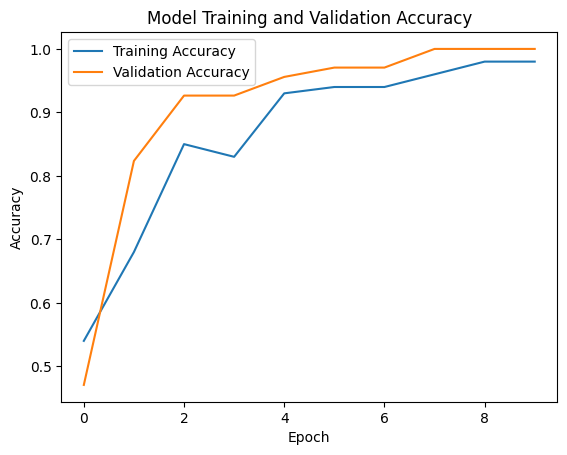

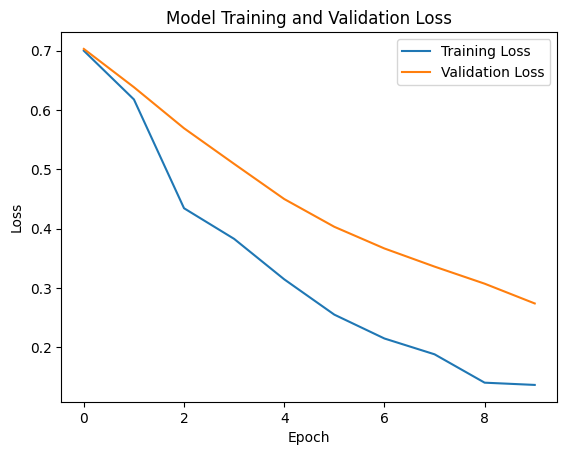

In [12]:
# Plot training and validation accuracy
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Training and Validation Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()
plt.show()

# Plot training and validation loss
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Training and Validation Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend()
plt.show()

In [13]:
from sklearn.metrics import f1_score

# predictions on test set
y_pred_prob = model.predict(X_test)
y_pred = (y_pred_prob > 0.5).astype(int).flatten()

# F1 score
f1 = f1_score(y_test, y_pred)
print(f"F1 Score: {f1}")

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 226ms/step
F1 Score: 0.9795918367346939
